# Ydata Data Science School
## Linear Regression & Regularization Exercise.


## Outline
In this exercise you will learn the following topics:

1. Refresher on how linear regression is solved in batch and in Gradient Descent
2. Implementation of Ridge Regression
3. Comparing Ridge, Lasso and vanila Linear Regression on a dataset

## Refresher on Ordinary Least Square (OLS) aka Linear Regeression

### Lecture Note

In Matrix notation, the matrix $X$ is of dimensions $n \times p$ where each row is an example and each column is a feature dimension.

Similarily, $y$ is of dimension $n \times 1$ and $w$ is of dimensions $p \times 1$.

The model is $\hat{y}=X\cdot w$ where we assume for simplicity that $X$'s first columns equals to 1 (one padding), to account for the bias term.

Our objective is to optimize the loss $L$ defines as resiudal sum of squares (RSS):

$L_{RSS}=\frac{1}{N}\left\Vert Xw-y \right\Vert^2$ (notice that in matrix notation this means summing over all examples, so $L$ is scalar.)

To find the optimal $w$ one needs to derive the loss with respect to $w$.

$\frac{\partial{L_{RSS}}}{\partial{w}}=\frac{2}{N}X^T(Xw-y)$ (to see why, read about [matrix derivatives](http://www.gatsby.ucl.ac.uk/teaching/courses/sntn/sntn-2017/resources/Matrix_derivatives_cribsheet.pdf) or see class notes )

Thus, the gardient descent solution is $w'=w-\alpha \frac{2}{N}X^T(Xw-y)$.

Solving $\frac{\partial{L_{RSS}}}{\partial{w}}=0$ for $w$ one can also get analytical solution:

$w_{OLS}=(X^TX)^{-1}X^Ty$

The first term, $(X^TX)^{-1}X^T$ is also called the pseudo inverse of $X$.

See [lecture note from Stanford](https://web.stanford.edu/~mrosenfe/soc_meth_proj3/matrix_OLS_NYU_notes.pdf) for more details.


## Exercise 1 - Ordinary Least Square
* Get the boston housing dataset by using the scikit-learn package. hint: [load_boston](https://scikit-learn.org/0.15/modules/generated/sklearn.datasets.load_boston.html)

* What is $p$? what is $n$ in the above notation? hint: [shape](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.ndarray.shape.html)

* write a model `OrdinaryLinearRegression` which has a propoery $w$ and 3 methods: `fit`, `predict` and `score` (which returns the MSE on a given sample set). Hint: use [numpy.linalg.pinv](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.linalg.pinv.html) to be more efficient.

* Fit the model. What is the training MSE?

* Plot a scatter plot where on x-axis plot $Y$ and in the y-axis $\hat{Y}_{OLS}$

* Split the data to 75% train and 25% test 20 times. What is the average MSE now for train and test? Hint: use [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) or [ShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html).

* Use a t-test to proove that the MSE for training is significantly smaller than for testing. What is the p-value? Hint: use [scipy.stats.ttest_rel](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ttest_rel.html).

* Write a new class `OrdinaryLinearRegressionGradientDescent` which inherits from `OrdinaryLinearRegression` and solves the problem using gradinet descent. The class should get as a parameter the learning rate and number of iteration. Plot the class convergance. What is the effect of learning rate? How would you find number of iteration automatically? Note: Gradient Descent does not work well when features are not scaled evenly (why?!). Be sure to normalize your features first.

* The following parameters are optional (not mandatory to use):
    * early_stop - True / False boolean to indicate to stop running when loss stops decaying and False to continue.
    * verbose- True/False boolean to turn on / off logging, e.g. print details like iteration number and loss (https://en.wikipedia.org/wiki/Verbose_mode)
    * track_loss - True / False boolean when to save loss results to present later in learning curve graphs

In [1]:
# * write a model `Ols` which has a propoery $w$ and 3 methods: `fit`, `predict` and `score`.? hint: use [numpy.linalg.pinv](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.linalg.pinv.html) to be more efficient.
import numpy as np

class Ols(object):
  def __init__(self):
    self.w = None

  @staticmethod
  def pad(X):
    n, m = X.shape  
    ones = np.ones((n, 1))
    return np.concatenate([X, ones], axis=1)

  def fit(self, X, Y):
   self._fit(X, Y)
 
  def _fit(self, X, Y):
    X2 = self.pad(X)
    X_transp_dot = np.dot(X2.T, X2)
    X_inv = np.linalg.inv(X_transp_dot) 
    X_inv_X = np.dot(X_inv, X2.T)
    result = np.dot(X_inv_X, Y)
    self.w = result.flatten()

  def predict(self, X):
    return self._predict(X)
 
  def _predict(self, X):
    coef = np.dot(self.pad(X), self.w)
    return coef.flatten()

  def score(self, X, Y):
    Y_pred = self.predict(X)
    MSE = Y - Y_pred
    MSE = np.mean(MSE**2)
    return MSE

In [44]:
# Write a new class OlsGd which solves the problem using gradinet descent.
# The class should get as a parameter the learning rate and number of iteration.
# Plot the loss convergance. for each alpha, learning rate plot the MSE with respect to number of iterations.
# What is the effect of learning rate?
# How would you find number of iteration automatically?
# Note: Gradient Descent does not work well when features are not scaled evenly (why?!). Be sure to normalize your feature first.
class Normalizer():
  def __init__(self):
    pass

  def fit(self, X):
    self.mean = np.mean(X, axis=0)
    self.std = np.std(X, axis=0)
    
  def predict(self, X):
    return (X - self.mean) / self.std
    

class OlsGd(Ols):

  def __init__(self, learning_rate=.05,
               num_iteration=1000,
               normalize=True,
               early_stop=True,
               verbose=True):

    super(OlsGd, self).__init__()
    self.learning_rate = learning_rate
    self.num_iteration = num_iteration
    self.early_stop = early_stop
    self.normalize = normalize
    self.normalizer = Normalizer()
    self.verbose = verbose

  def _fit(self, X, Y, reset=True, track_loss=True):
    if self.normalize:
        self.normalizer.fit(X)
        X_norm = self.normalizer.predict(X)
    else:
        X_norm = X
    X_norm = self.pad(X_norm)

    n, m = X_norm.shape
    w = np.random.randn(m)*0.01
    self.losses = []
    for i in range(self.num_iteration):
        loss = np.dot(X_norm, w) - Y
        grad = self.learning_rate*1/n*(np.dot(X_norm.T, loss))
        if self.early_stop and np.linalg.norm(grad - w) < 1e-6:
            break
        if track_loss:
            self.losses.append(loss)
        w = w - grad
        if self.verbose:
            print("Weights: {}, loss: {}".format(w, loss))
    self.w = w


  def _predict(self, X):
    if self.normalize:
        self.normalizer.fit(X)
        X_norm = self.normalizer.predict(X)
    else:
        X_norm = X
    coef = np.dot(self.pad(X_norm), self.w)
    return coef.flatten()  

  def _step(self, X, Y):
    # use w update for gradient descent
    pass

In [3]:
import pandas as pd

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]
data.shape

(506, 13)

In [4]:
boston_model = Ols()
boston_model.fit(data, target)
target_pred = boston_model.predict(data)
boston_model.score(data, target)

21.894831181729206

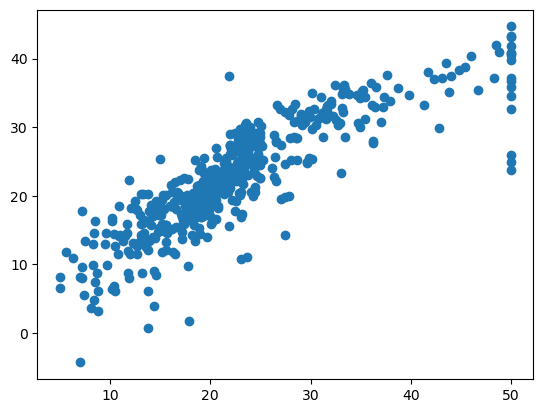

In [5]:
import matplotlib.pyplot  as plt

plt.scatter(target, target_pred)
plt.show()


In [6]:
from sklearn.model_selection import train_test_split

MSE_train = []
MSE_test = []
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25)
    boston_model.fit(X_train, y_train)
    #boston_model.predict(X_test)
    MSE_train.append(boston_model.score(X_train, y_train))
    MSE_test.append(boston_model.score(X_test, y_test))

print('Average MSE on train:',np.mean(MSE_train))
print('Average MSE on test:', np.mean(MSE_test))

Average MSE on train: 21.791753168790926
Average MSE on test: 23.29066514155742


In [9]:
from scipy.stats import ttest_rel

t_stat, p_value = ttest_rel(MSE_train, MSE_test,alternative='less')
p_value

0.17623367252918065

MSE for the test dataset is not significantly different from the MSE of the training dataset

In [45]:
mse_train = []
mse_test = []
alpha_range = np.arange(0.001,0.061,0.005)
for alpha in alpha_range:
  X_train, X_test, Y_train, Y_test = train_test_split(data, target, test_size=0.25)
  model = OlsGd(learning_rate=alpha, verbose=False)
  model.fit(X_train,Y_train)
  mse_train.append(model.score(X_train,Y_train))
  mse_test.append(model.score(X_test,Y_test))

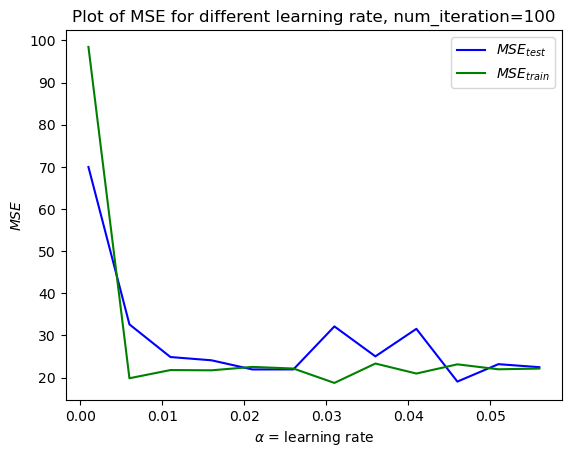

In [46]:
plt.plot(alpha_range,mse_test,color='blue',label='$MSE_{test}$')
plt.plot(alpha_range,mse_train,color='green',label='$MSE_{train}$')
plt.title('Plot of MSE for different learning rate, num_iteration=100')
plt.legend()
plt.ylabel('$MSE$')
plt.xlabel('$\\alpha$ = learning rate')
plt.show()

With a small learning rate, gradient descent slowly approach to the correct weights $w$, requiring more iterations to approach to the correct weights $w$. Larger steps approach weights $w$ faster,what requirs fewer iterations

How would you find number of iteration automatically?


At values ​​of n at which the MSE value does not change much

 Gradient Descent does not work well when features are not scaled evenly (why?!).
 If features are not scaled so $\\w$ also not scaled (It could be $\\w_1=10$ and $\\w =10^{10}$.It is not neccery that GD will find this minimum of MSE. Also it affects the speed of gradient descent.
 (Before normalization level lines of MSE are elongated ovals, after it is a round)

## Exercise 2 - Ridge Linear Regression

Recall that ridge regression is identical to OLS but with a L2 penalty over the weights:

$L(y,\hat{y})=\sum_{i=1}^{i=N}{(y^{(i)}-\hat{y}^{(i)})^2} + \lambda \left\Vert w \right\Vert_2^2$

where $y^{(i)}$ is the **true** value and $\hat{y}^{(i)}$ is the **predicted** value of the $i_{th}$ example, and $N$ is the number of examples

* Show, by differentiating the above loss, that the analytical solution is $w_{Ridge}=(X^TX+\lambda I)^{-1}X^Ty$
* Change `OrdinaryLinearRegression` and `OrdinaryLinearRegressionGradientDescent` classes to work also for ridge regression. Either add a parameter, or use inheritance.
* **Bonus: Noise as a regularizer**: Show that OLS (ordinary least square), if one adds multiplicative noise to the features the **average** solution for $W$ is equivalent to Ridge regression. In other words, if $X'= X*G$ where $G$ is an uncorrelated noise with variance $\sigma$ and mean 1, then solving for $X'$ with OLS is like solving Ridge for $X$. What is the interpretation?



$L = (Xw - y)^T(Xw - y) + λw^Tw → min$

$∇_w L = X^T(Xw-y) + (Xw-y)^TX + λ(I^Tw + w^TI) = X^TXw-X^Ty + X^T(Xw-y) +λ(I^Tw+I^Tw) =$
$= 2X^TXw-2X^Ty+2λI^Tw = 0$

$(X^TX+λI^T)w = X^Ty$

$w = (X^TX + λI^T)^{-1}X^Ty$

$w = (X^TX + λI)^{-1}X^Ty$

In [30]:
class RidgeLs(Ols):
  def __init__(self, ridge_lambda, *wargs, **kwargs):
    super(RidgeLs,self).__init__(*wargs, **kwargs)
    self.ridge_lambda = ridge_lambda

  def _fit(self, X, Y):
    X2 = self.pad(X)
    I = np.eye(X2.shape[1])
    X_transp_dot = np.dot(X2.T, X2) + self.ridge_lambda * I
    X_inv = np.linalg.pinv(X_transp_dot) 
    X_inv_X = np.dot(X_inv, X2.T)
    result = np.dot(X_inv_X, Y)
    self.w = result.flatten()


In [73]:
class RidgeLsGd(OlsGd):
  def __init__(self, ridge_lambda, *wargs, **kwargs):
    super(RidgeLsGd,self).__init__(*wargs, **kwargs)
    self.ridge_lambda = ridge_lambda
      
  def _fit(self, X, Y, reset=True, track_loss=True):
    if self.normalize:
        self.normalizer.fit(X)
        X_norm = self.normalizer.predict(X)
    else:
        X_norm = X
    X_norm = self.pad(X_norm)

    n, m = X_norm.shape
    w = np.random.randn(m)*0.01
    self.losses = []
    for i in range(self.num_iteration):
        loss = np.dot(X_norm, w) - Y
        grad = self.learning_rate*2/n*(np.dot(X_norm.T, loss) + self.ridge_lambda*w)
        if self.early_stop and np.linalg.norm(grad - w) < 1e-6:
            break
        if track_loss:
            self.losses.append(loss)
        w = w - grad
        if self.verbose:
            print("Weights: {}, loss: {}".format(w, loss))
    self.w = w

In [79]:
model = RidgeLsGd(ridge_lambda = 1, verbose=False)
model._fit(X_train,Y_train)
model.predict(X_test)
print('MSE on train:',model.score(X_train,Y_train))
print('MSE on test:',model.score(X_test,Y_test))
model = Ols()
model.fit(X_train,Y_train)
model.predict(X_test)
print('MSE on train:',model.score(X_train,Y_train))
print('MSE on test:',model.score(X_test,Y_test))

MSE on train: 22.125985445016724
MSE on test: 22.493165442941685
MSE on train: 22.12067568581293
MSE on test: 22.887349246258463


### Use scikitlearn implementation for OLS, Ridge and Lasso

In [61]:
from sklearn import linear_model

model_ols = linear_model.LinearRegression()
model_ols.fit(data, target)
print(model_ols.coef_)

model_ols_2 = Ols()
model_ols_2.fit(data, target)
print(model_ols_2.w)

[-1.08011358e-01  4.64204584e-02  2.05586264e-02  2.68673382e+00
 -1.77666112e+01  3.80986521e+00  6.92224640e-04 -1.47556685e+00
  3.06049479e-01 -1.23345939e-02 -9.52747232e-01  9.31168327e-03
 -5.24758378e-01]
[-1.08011358e-01  4.64204584e-02  2.05586264e-02  2.68673382e+00
 -1.77666112e+01  3.80986521e+00  6.92224640e-04 -1.47556685e+00
  3.06049479e-01 -1.23345939e-02 -9.52747232e-01  9.31168327e-03
 -5.24758378e-01  3.64594884e+01]


In [84]:
model_ridge = linear_model.Ridge(alpha=1.0) 
model_ridge.fit(data, target)
print(model_ridge.coef_)

model_ridge_2 = RidgeLsGd(1.0, verbose=False, early_stop=False) 
model_ridge_2.fit(data, target)
print(model_ridge_2.w)

[-1.04595278e-01  4.74432243e-02 -8.80467889e-03  2.55239322e+00
 -1.07770146e+01  3.85400020e+00 -5.41453810e-03 -1.37265353e+00
  2.90141589e-01 -1.29116463e-02 -8.76074394e-01  9.67327945e-03
 -5.33343225e-01]
[-9.19659664e-01  1.06608834e+00  1.16228477e-01  6.85292370e-01
 -2.02880911e+00  2.68296365e+00  1.29809106e-02 -3.07742392e+00
  2.58861996e+00 -2.00724074e+00 -2.05227677e+00  8.48827836e-01
 -3.73055393e+00  2.24883629e+01]


In [83]:
model_lasso = linear_model.Lasso(alpha=0.1) 
model_lasso.fit(data, target)
print(model_lasso.coef_)

[-0.09789363  0.04921111 -0.03661906  0.95519003 -0.          3.70320175
 -0.01003698 -1.16053834  0.27470721 -0.01457017 -0.77065434  0.01024917
 -0.56876914]
